In [1]:
from jax import numpy as jnp
from typing import Tuple,Dict, Callable, List, Any
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpyro
from pathlib import WindowsPath,PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
MODEL_INFERENCE_PATH = PARENT_DIR.joinpath('.model_inference')
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
import pickle
from common_util import setup_axis_default, jmak_fit_model_setup,get_data_multiplier,\
                        _FILE_TO_LABEL as file_to_label

from typing import List, Dict, Tuple
from numpyro.distributions import Distribution
from statsmodels.regression.linear_model import OLS, OLSResults
from jax import vmap
from numpyro.distributions import MultivariateNormal, Uniform, TruncatedNormal
from matplotlib import rc
from numpyro.diagnostics import hpdi
from jax import random
rng_key = random.PRNGKey(92)
rng_key, rng_key_ = random.split(rng_key)

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
from common_util import get_data_label  
from model_inference.inflib import JMAKHierarchical,JMAKNumpyro,RxKineticHierarchicalNumpyro,RxKineticNumpyro, GLHierarchical, GLNumpyro

c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Compare The Posterior Predictives
of the JMAK model of single-inference vs. Combined Inference. 

No standard deviation column found, using 0.001 for all values


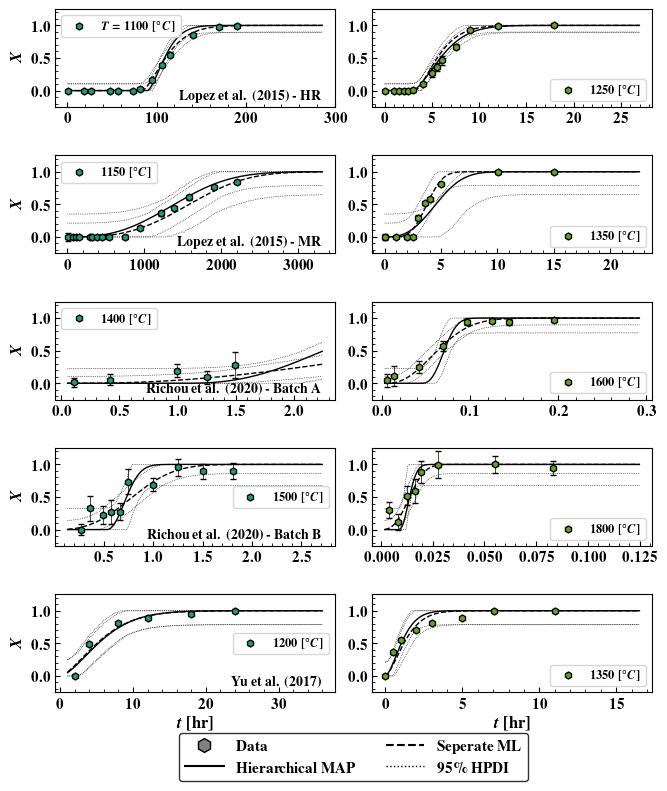

In [2]:

from matplotlib.lines import Line2D
from numpyro.distributions import Normal, LogNormal, TruncatedNormal
from jax import random
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)


def plot_posterior_prediction_seperate(ax: plt.Axes,
                              numpyro_model: RxKineticNumpyro,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    _, subkey = random.split(rng_key_)
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    lower, upper = numpyro_model.predictive_confidence_interval(
        subkey,
        t=jnp.asarray(t),
        T=(temperature + 273.15)*jnp.ones_like(t),
        std=jnp.zeros_like(t),   # or your actual df['std']
        alpha=0.95
    )
    ml_pred = numpyro_model.ml_prediction(t,(temperature + 273.15)*np.ones_like(t))

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    
def plot_posterior_prediction(ax: plt.Axes,
                              numpyro_model: RxKineticHierarchicalNumpyro,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              index: int, 
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    _, subkey = random.split(rng_key)
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    lower,upper = numpyro_model.predictive_confidence_interval_group(subkey,t,np.ones_like(t)*(temperature + 273.15),group_index = index)
    ml_Xhat = numpyro_model.map_prediction_group(t,np.ones_like(t)*(temperature + 273.15),group_index = index)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_Xhat,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    
def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[df['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes_ = plt.subplot_mosaic("""AB
                           CD
                           EF
                           GH
                           IJ
                           KK""",figsize = (6.5,7.75),height_ratios= [1,1,1,1,1,0.3333333])

axes = np.array([axes_[a] for a in ['A','B','C','D','E','F','G','H','I','J']]).reshape(5,2)
lax = axes_['K']
lax.axis('off')
legend = lax.legend(handles = [Line2D([],[],marker = 'h', markersize = 10,
                             markeredgecolor = 'k',lw = 0.0,markerfacecolor = 'grey',label = r'\textbf{Data}'),
                     Line2D([],[],lw = 1.5,ls = '-',color = 'k',label = r'\textbf{Hierarchical MAP}'),
                     Line2D([],[],lw = 1.5,ls = '--',color = 'k',label = r'\textbf{Seperate ML}'),
                     Line2D([],[],lw = 1.0,ls = ':',color = 'k',label = r'\textbf{95\% HPDI}')],
                        loc = 'center',fontsize = 11,frameon = True,ncols = 2,
                        handlelength = 2.5)

frame = legend.get_frame()
frame.set_linewidth(1.0)
frame.set_edgecolor('k')

file_to_index = {file: i for i,file in enumerate(list(file_to_label.keys()))}   
temperatures  = {'alfonso_data/highly_rolled.csv': [1100,1250],
                'alfonso_data/moderate_roll.csv': [1150,1350],
                'richou_data/batch_a_data.csv': [1400,1600],
                'richou_data/batch_b_data.csv': [1500,1800],
                 'yu_data/data.csv': [1200,1350]}

temperatures = {get_data_label(DATA_DIR.joinpath(file)): temps for file,temps in temperatures.items()}

model_name = 'JMAK_{}'
model_setup = jmak_fit_model_setup
ep_param = 'n'
color  = 'k'
style = '-'
heirarchical_model = JMAKHierarchical.load(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_model.pkl'))

for i,file in enumerate(list(file_to_label.keys())[:-1]): #count rows/datasets
    t,T,X,df,bounds,p0 = model_setup(file, mult = get_data_multiplier(file))  
    numpyro_model = JMAKNumpyro.load(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal.pkl'))
    for j,plot_temperature,exp_color in zip(range(2),temperatures[get_data_label(file)],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
        plot_posterior_prediction(axes[i,j],heirarchical_model,plot_temperature,df,i,style = '-',pred_color = color)        
        plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                make_label = True)
        plot_posterior_prediction_seperate(axes[i,j],numpyro_model,plot_temperature,df,style = '--',pred_color = color)

for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05,r'\textbf{' + data_label + '}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        #ax.set_xscale('log')   
        #final formatting

        if j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        elif i == 3 or i == 4:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'center right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.1) 
fig.savefig(GIT_IMAGE_PATH.joinpath('posterior_predictive_comparison_hierarchical_seperate.svg'))


In [4]:

def _get_predictions(model: RxKineticHierarchicalNumpyro | RxKineticNumpyro,
                     rng_key: jnp.ndarray,
                     t: jnp.ndarray,
                     T: jnp.ndarray,
                     std: jnp.ndarray = None,
                     **kwargs) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # 1) draw posterior predictive samples (n_draws, N)
    try:
        y_pred = model.sample_predictive_group(
            rng_key, t=t, T=T, std=std, **kwargs
        )  # shape (S, N)
    except AttributeError:
        y_pred = model.sample_predictive(
            rng_key, t=t, T=T, std=std, **kwargs
        )

    return y_pred

def bayes_r2(model: RxKineticHierarchicalNumpyro | RxKineticNumpyro,
                    rng_key: jnp.ndarray,
                    t: jnp.ndarray,
                    T: jnp.ndarray,
                    y: jnp.ndarray,
                    std: jnp.ndarray = None,
                    **kwargs,
                    ) -> jnp.ndarray:
    """
    Compute posterior draws of Bayesian R^2 for one group.

    Returns:
        r2: array shape (n_draws,) of R^2_s.
    """

    y_pred = _get_predictions(model, rng_key, t, T, std=std, **kwargs)

    # 2) compute per‐draw variances
    var_pred  = jnp.var(y_pred,     axis=1)   # shape (S,)
    var_resid = jnp.var(y - y_pred, axis=1)   # shape (S,)

    # 3) Bayes R^2 per draw
    return var_pred / (var_pred + var_resid)


def coverage_probability(
    model: RxKineticHierarchicalNumpyro | RxKineticNumpyro,
    rng_key: jnp.ndarray,
    t: jnp.ndarray,
    T: jnp.ndarray,
    y: jnp.ndarray,
    std: jnp.ndarray = None,
    alpha: float = 0.95,
    tol: float = 1e-4,
    **kwargs
) -> float:
    """
    Compute the proportion of y_i that lie within the central 
    100*alpha% posterior predictive interval. Tolerance acccounts for the 
    asmpytoci nature of the likelihood and the truncated version used.

    Returns:
      coverage: scalar in [0,1]
    """
    try:
        lo,hi = model.predictive_confidence_interval(
            rng_key, t=t, T=T, std=std, alpha=alpha, **kwargs
        )  # shape (N,)
    except AttributeError:
        lo,hi = model.predictive_confidence_interval_group(
            rng_key, t=t, T=T, std=std, alpha=alpha, **kwargs
        )

    # 3) check coverage
    inside = (y >= lo - tol) & (y <= hi + tol)  # boolean array (N,)
    return inside

def crps(
    model: RxKineticHierarchicalNumpyro | RxKineticNumpyro,
    rng_key: jnp.ndarray,
    t: jnp.ndarray,
    T: jnp.ndarray,
    y: jnp.ndarray,
    std: jnp.ndarray = None,
    **kwargs
) -> jnp.ndarray:
    """
    Compute per‐obs CRPS = E|X−y| − ½ E|X−X'| 
    without ever forming an (S,S,N) array or overflowing.
    """
    # 1) draw S×N predictive samples
    y_pred = _get_predictions(model, rng_key, t, T, std=std, **kwargs)
    # (optionally cast to float64 for extra headroom)
    y_pred = y_pred.astype(jnp.float64)
    S, N = y_pred.shape
    S = jnp.float64(S)  # cast to float64 for extra headroom

    # 2) term1 = E[|X − y|]
    term1 = jnp.mean(jnp.abs(y_pred - y[None, :]), axis=0)

    # 3) term2 = ½ E[|X − X'|] via sorted identity
    #    3a) sort each column
    sorted_preds = jnp.sort(y_pred, axis=0)    # shape (S, N)

    #    3b) build a *normalized* index vector so weights are O(1/S)
    idx = jnp.arange(1, S+1, dtype=jnp.float64)   # [1,2,…,S]
    idx_norm = idx / (S**2)                        # now ~O(1/S)

    #    3c) dot it through: idx_norm @ sorted_preds  → shape (N,)
    #        this computes (1/S²) * sum_i i * x_(i) for each column
    s1 = jnp.dot(idx_norm, sorted_preds)

    #    3d) we still need the −((S+1)/S)·mean term
    mean_pred = jnp.mean(sorted_preds, axis=0)

    #    3e) put it together
    term2 = 2 * s1 - ((S + 1) / S) * mean_pred

    return term1 - term2


model_name = 'JMAK_{}'
model_setup = jmak_fit_model_setup
ep_param = 'n'

stats = pd.DataFrame(np.zeros([5,4]),columns = ['bayes_r2','coverage_probability','crps', 'sigma'],
                     index = list(file_to_label.values())[:-1])

for i,file in enumerate(list(file_to_label.keys())[:-1]):
    t,T,X,df,bounds,p0 = model_setup(file, mult = get_data_multiplier(file))  
    numpyro_model = JMAKHierarchical.load(MODEL_INFERENCE_PATH.joinpath(model_name.format(f'hierarchical_trunc_normal_model.pkl')))
    stats.loc[file_to_label[file],'bayes_r2'] = np.median(bayes_r2(numpyro_model,rng_key,t,T,X,std = df['std'].values,group_index = i))
    cp = coverage_probability(numpyro_model,rng_key,t,T,X,std = df['std'].values,group_index = i)
    stats.loc[file_to_label[file],'coverage_probability'] = float(cp.mean())
    stats.loc[file_to_label[file ],'crps']  = float(np.mean(crps(numpyro_model,rng_key,t,T,X,std = df['std'].values,group_index = i)))
    stats.loc[file_to_label[file],'sigma'] = float(np.mean(numpyro_model.posterior_samples['sigma'],axis = 0)[i])   
    label = file_to_label[file]

stats = np.round(stats,3)
print(stats)
stats.to_csv(GIT_TABLE_PATH / 'jmak_hierarchical_stats.csv')


No standard deviation column found, using 0.001 for all values
                                bayes_r2  coverage_probability   crps  sigma
Lopez et al. (2015) - HR           0.948                 0.951  0.037  0.055
Lopez et al. (2015) - MR           0.609                 0.914  0.104  0.176
Richou et al. (2020) - Batch A     0.845                 0.950  0.066  0.108
Richou et al. (2020) - Batch B     0.739                 1.000  0.080  0.156
Yu et al. (2017)                   0.872                 0.969  0.053  0.107
